## IGO17131 KP Hopx-MACD Rosa26 - mTmG/+ exposed to Tamoxifen for 3d at 12 weeks
3/27/2025 - Data generated from 12 week KP Slc4a11-MCD/+ Hipp11-BG/+ tumors; data submitted by CHP/EB on 3/20/2025, extra sequencing included; analyzed by JC 6/8/2025

Analyze global run on cellranger v8 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib

import anndata
from pathlib import Path

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/IGO17131-Hopx-mTmG-3d_traced.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_h5('GSE277777_IGO17131-filtered_feature_bc_matrix.h5', gex_only=False)

reading GSE277777_IGO17131-filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [8]:
print(samples)

['BP1487', 'BN1492', 'BO1522', '112012-1', '112012-2']


In [9]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [10]:
hashadata.var

gene_ids     feature_types genome                    pattern read  \
BP1487      BP1487  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
BN1492      BN1492  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
BO1522      BO1522  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
112012-1  112012-1  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
112012-2  112012-2  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   R2   

                 sequence  
BP1487    ACCCACCAGTAAGAC  
BN1492    GGTCGAGAGCATTCA  
BO1522    CTTGCCGCATGTCAT  
112012-1  AAAGCATTCTTCACG  
112012-2  CTTTGTCTTTGTGAG

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


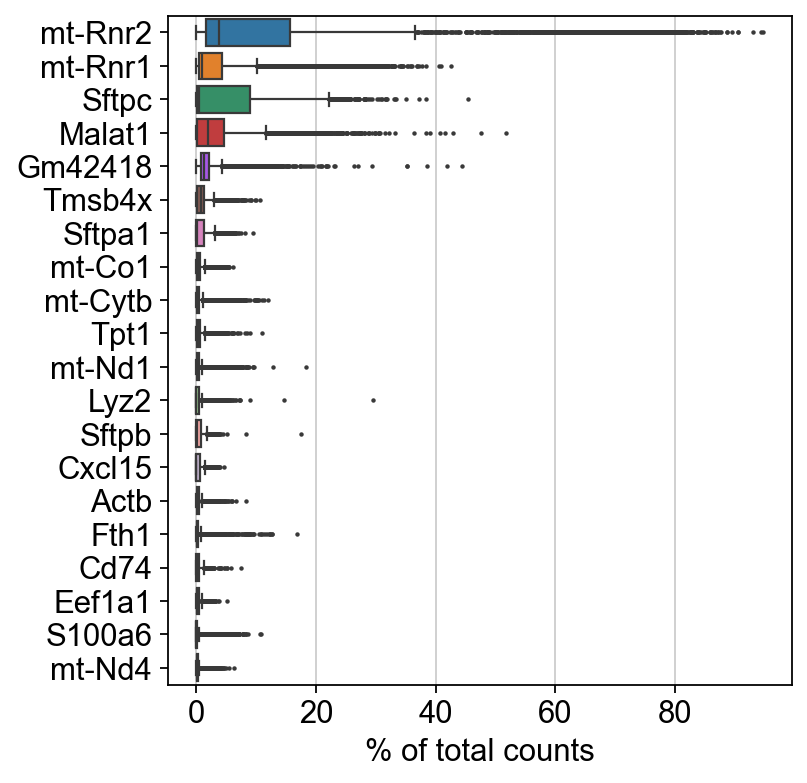

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [12]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2090 cells that have less than 1500 counts
filtered out 1655 cells that have less than 300 genes expressed
filtered out 31955 genes that are detected in less than 3 cells


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

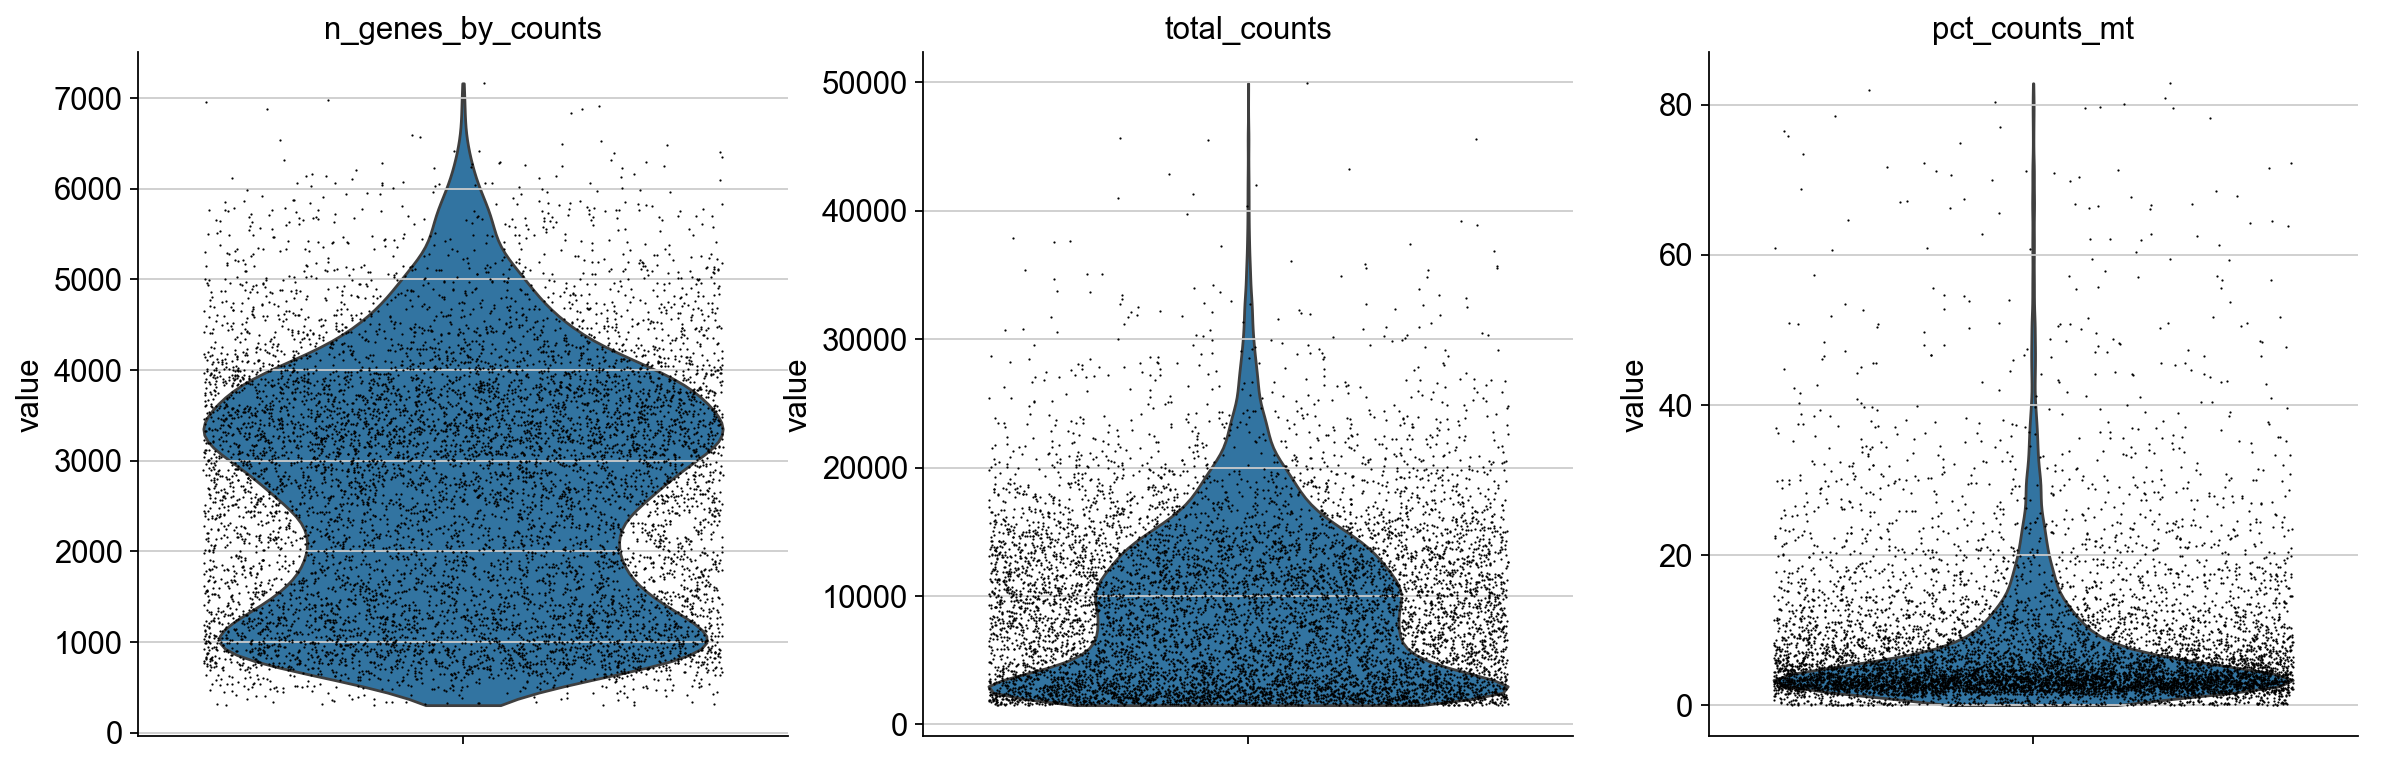

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([   7.,   20.,   37.,   73.,  188., 1070., 3369., 2782., 1036.,
          62.]),
 array([0.71390355, 0.73738553, 0.7608675 , 0.78434948, 0.80783145,
        0.83131343, 0.85479541, 0.87827738, 0.90175936, 0.92524134,
        0.94872331]),
 <BarContainer object of 10 artists>)

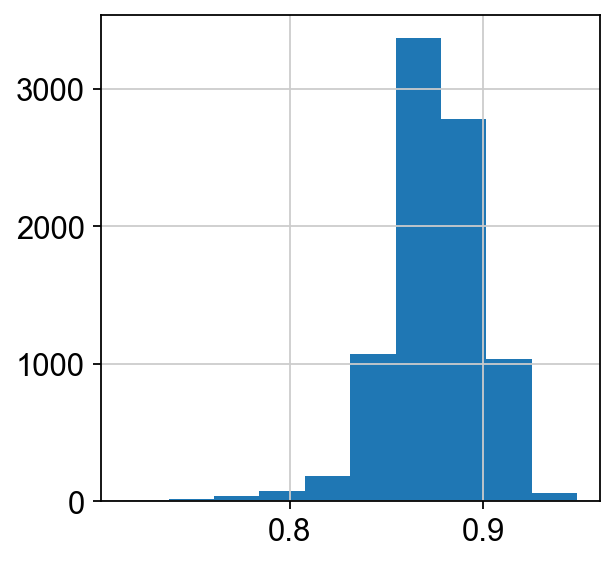

In [15]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

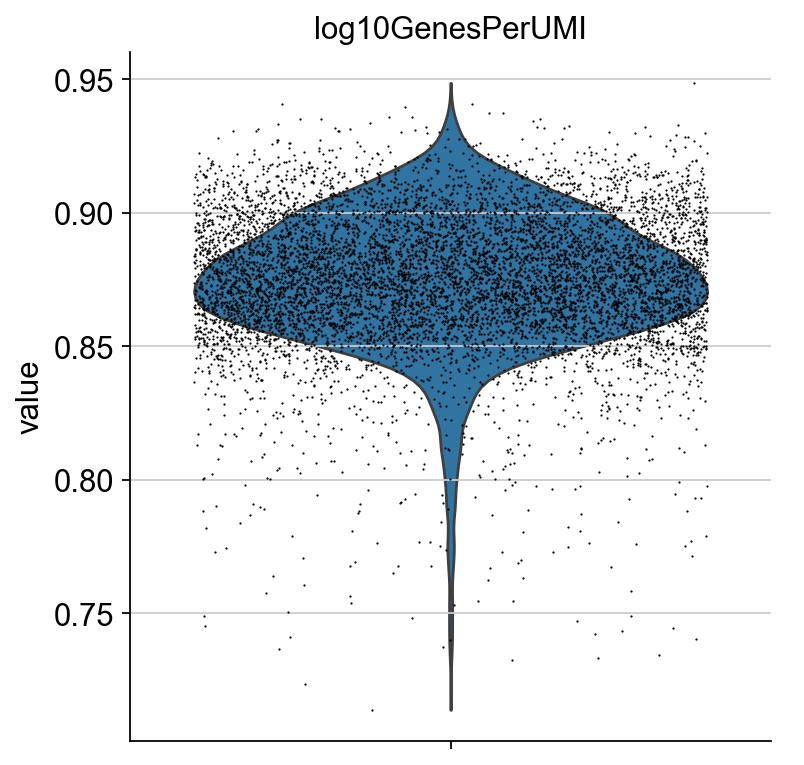

In [16]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

Keep singlets, remove cells that have too many mouse reads, or mitochondrial genes expressed or too many total counts:

In [17]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [18]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [19]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [20]:
hashadata.var_names

Index(['BP1487', 'BN1492', 'BO1522', '112012-1', '112012-2'], dtype='object')

In [21]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [22]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

BP1487        BN1492        BO1522     112012-1     112012-2
count  7856.000000   7856.000000   7856.000000  7856.000000  7856.000000
mean     65.907204    400.750397    433.902740    29.195902   209.109467
std     446.085419    841.203430    737.776245    54.920010   158.623642
min       0.000000      0.000000      0.000000     0.000000     3.000000
10%       2.000000     27.000000     13.000000    16.000000   125.000000
20%       3.000000     32.000000     17.000000    19.000000   141.000000
30%       4.000000     36.000000     21.000000    21.000000   153.000000
40%       4.000000     42.000000     31.000000    23.000000   165.000000
50%       5.000000     53.000000    117.000000    25.000000   178.000000
60%       6.000000    105.000000    257.000000    27.000000   192.000000
70%       7.000000    267.000000    447.000000    29.000000   210.000000
80%       9.000000    559.000000    707.000000    32.000000   236.000000
90%      12.000000   1143.000000   1230.000000    36.000000   311.500000
99%    2217.050000   4116.650000   3472.300000    80.450000   728.000000
max    9772.000000  12270.000000  12590.000000  2312.000000  5188.000000

In [23]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

BP1487
12.0
BN1492
1143.0
BO1522
1230.0
112012-1
36.0
112012-2
311.5


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

BP1487  BN1492  BO1522  112012-1  112012-2
AAACCAAAGCCATCAA-1   False   False   False     False     False
AAACCAAAGCGCTTCC-1   False   False   False     False     False
AAACCAAAGCTAACTG-1   False   False   False     False     False
AAACCAAAGGGCTGAA-1   False   False   False     False     False
AAACCAAAGGTTCGAC-1   False   False   False     False     False
...                    ...     ...     ...       ...       ...
TGTGTACGTGGCCAGA-1   False   False   False     False     False
TGTGTACGTTGCATGT-1   False   False   False     False     False
TGTGTTGAGAAGCATA-1    True   False    True     False     False
TGTGTTGAGCTTACCT-1   False    True   False     False     False
TGTGTTGAGGTAATTC-1   False   False   False     False     False

[7856 rows x 5 columns]

In [24]:
from matplotlib import pyplot as plt

In [25]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

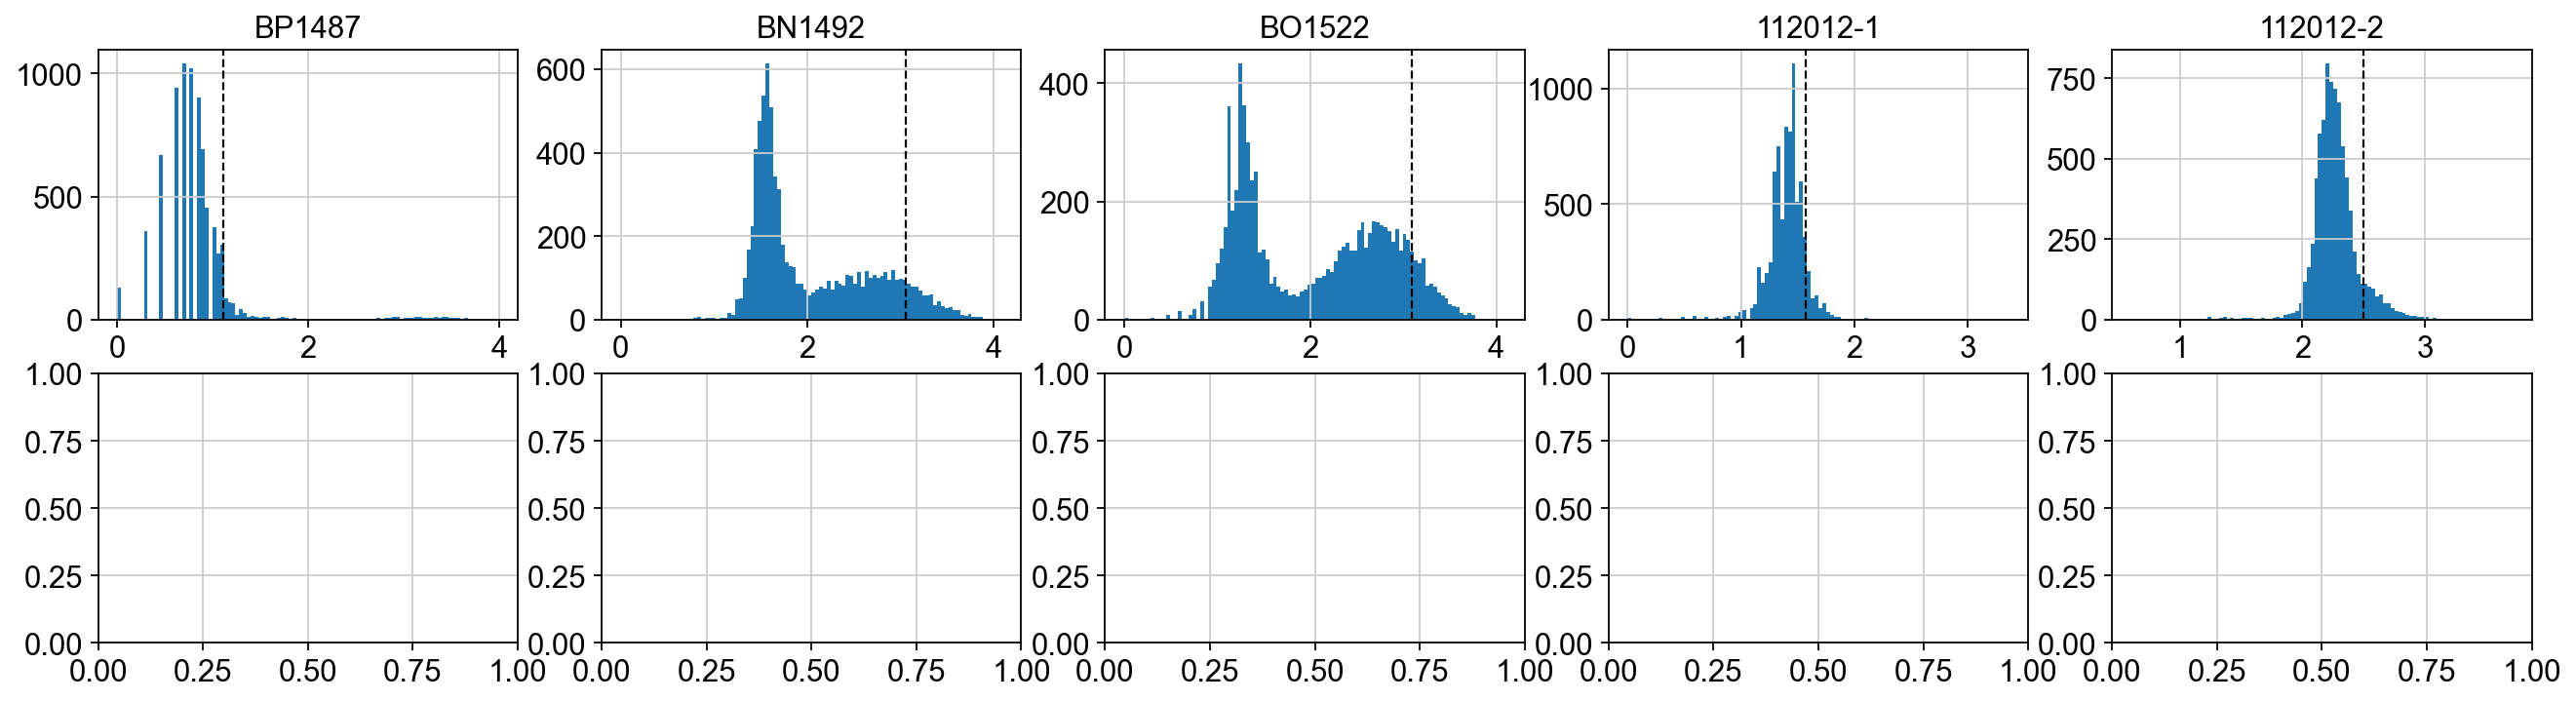

In [26]:
fig, axs = plt.subplots(2,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

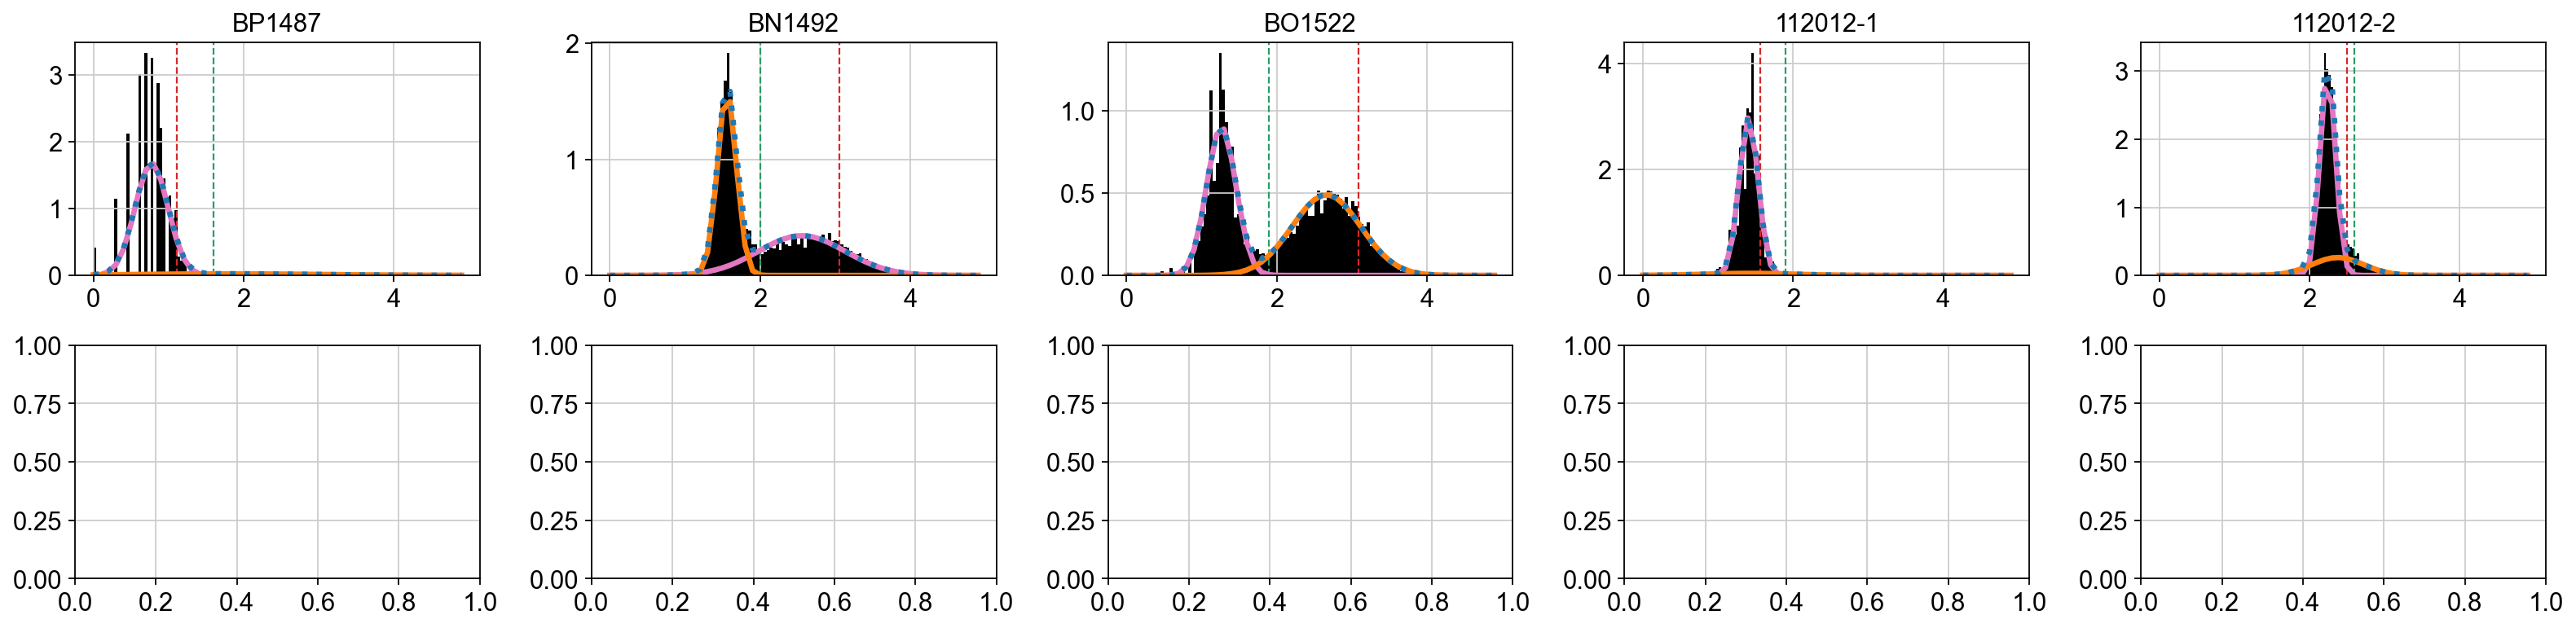

In [27]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]    
    if mean[0][0] < mean[1][0]:
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [28]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BP1487
1.6
BN1492
2.0
BO1522
1.9000000000000001
112012-1
1.9000000000000001
112012-2
2.6


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False  True ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/416796475.py:6: FutureWarning: Setting an item of incompati

In [29]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    #print(i)
    #print(hashBool)
    #print(hashBool.values)
    #print(sum(hashBool))
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [30]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BO1522      3098
BN1492      2199
doublet     1268
negative    1084
BP1487       123
112012-2      70
112012-1      14
Name: count, dtype: int64

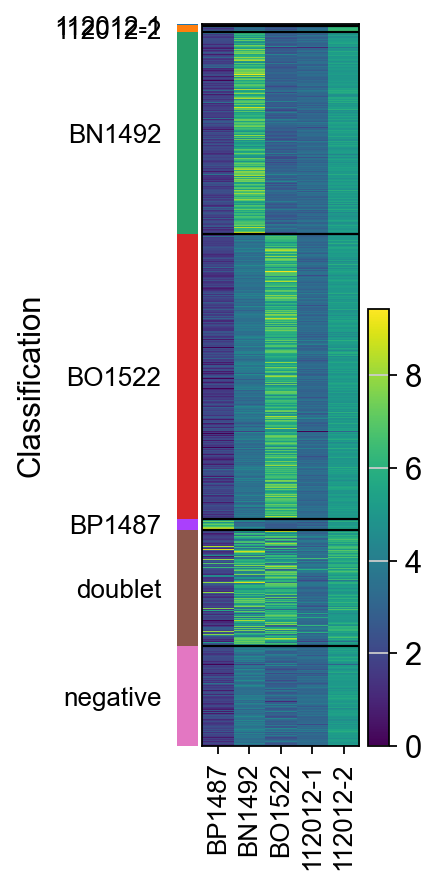

In [31]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set highly variable genes before moving all mean to 0

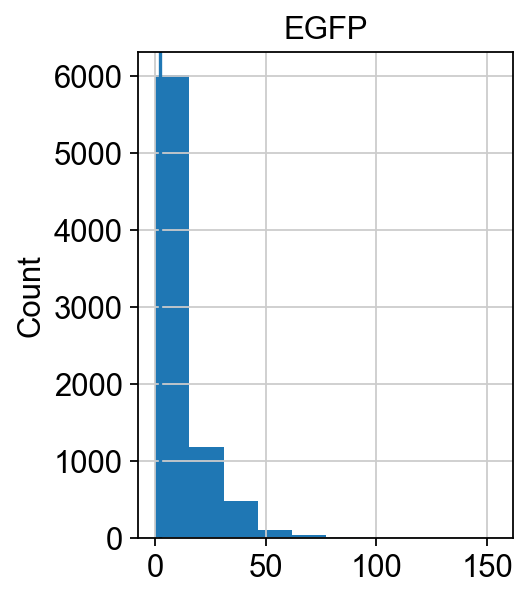

In [32]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [33]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

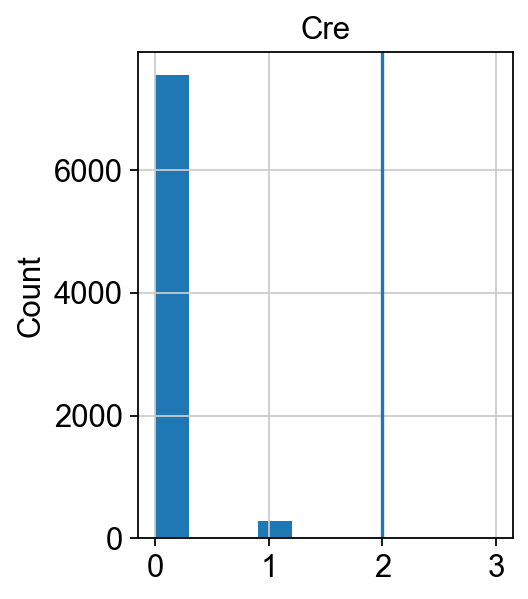

In [34]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [35]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

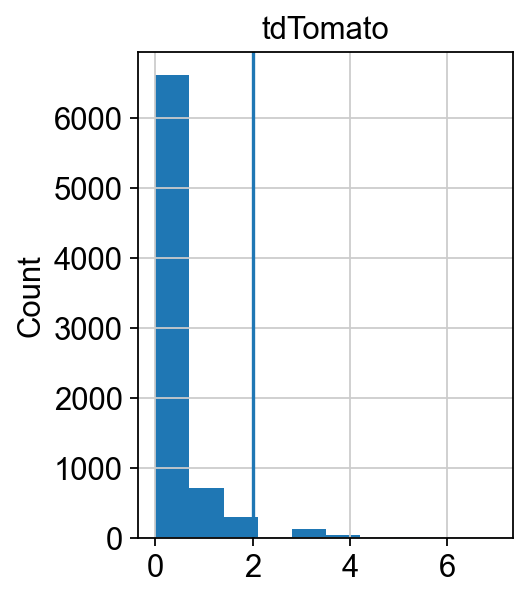

In [36]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [37]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

## Filter doublets and negative cells

In [38]:
adata.obs.Classification.value_counts()

Classification
BO1522      3098
BN1492      2199
doublet     1268
negative    1084
BP1487       123
112012-2      70
112012-1      14
Name: count, dtype: int64

In [39]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative','112012-2','112012-1']),:]

In [40]:
adata.obs.Classification.value_counts()

Classification
BO1522    3098
BN1492    2199
BP1487     123
Name: count, dtype: int64

## Set Groups

In [41]:
samples

['BP1487', 'BN1492', 'BO1522', '112012-1', '112012-2']

In [42]:
#Set groups
adata.obs['Group'] = 'Hopx_traced_3d'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/782455014.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'Hopx_traced_3d'


## Run basic normaliztaions

In [43]:
adata.layers['counts']=adata.X.copy()

In [44]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [45]:
sc.pp.log1p(adata)

In [46]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


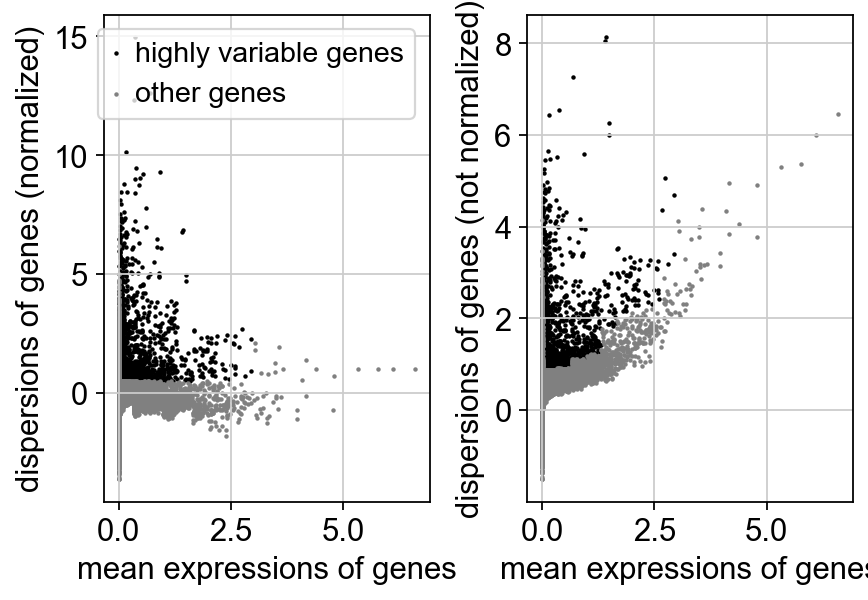

In [47]:
sc.pl.highly_variable_genes(adata)

In [48]:
#will need to update this after realignment
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/2467826253.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/246782

In [49]:
adata.write('write/allmice-IGO17131.h5ad', compression='gzip')

In [50]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## Principal component analysis

In [51]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:01)


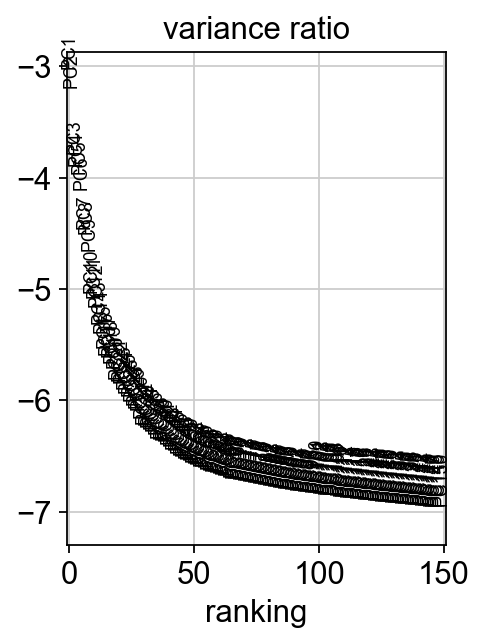

In [52]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

Save the result.

In [53]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [54]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [55]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


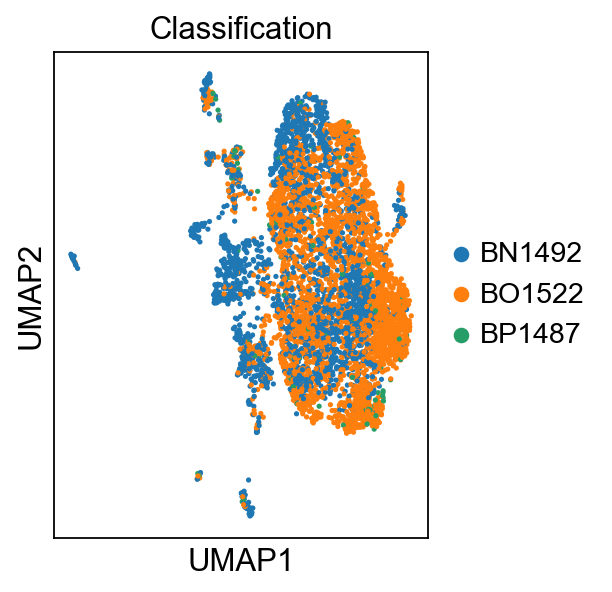

In [56]:
sc.pl.umap(adata, color=['Classification'])

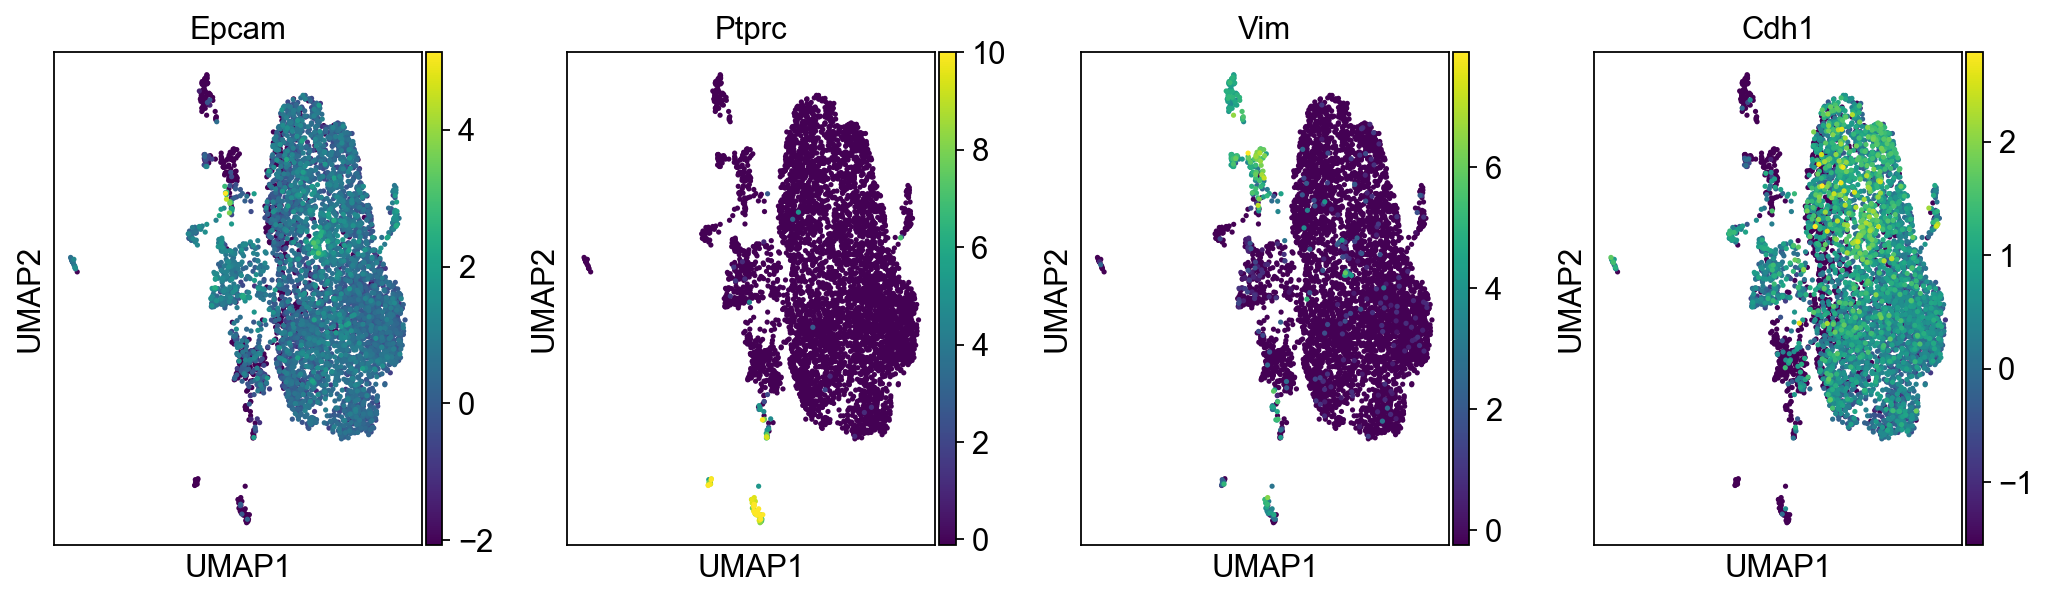

In [57]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

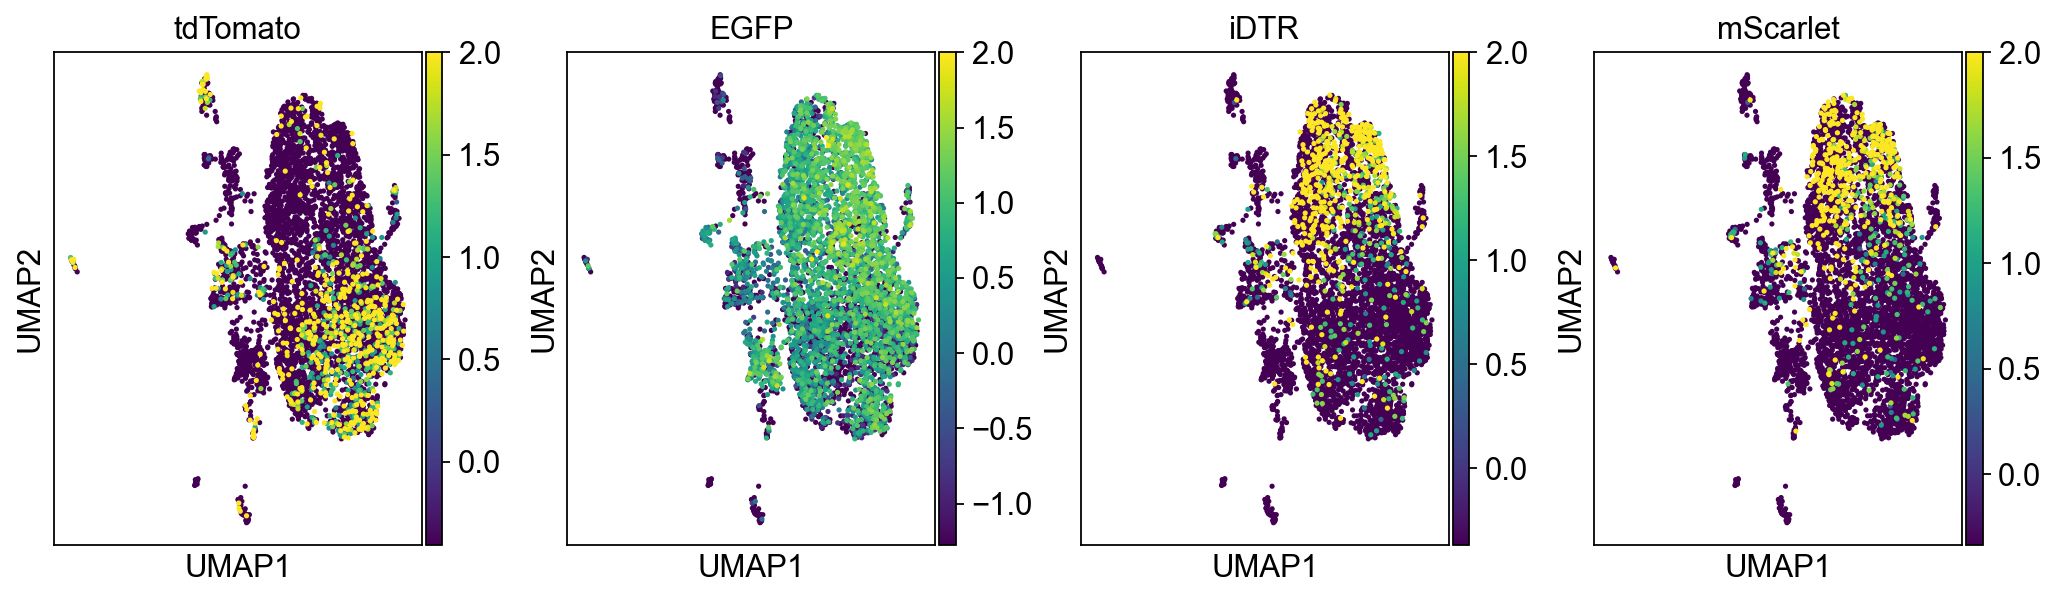

In [58]:
sc.pl.umap(adata, color=['tdTomato','EGFP','iDTR','mScarlet'], vmax=2)

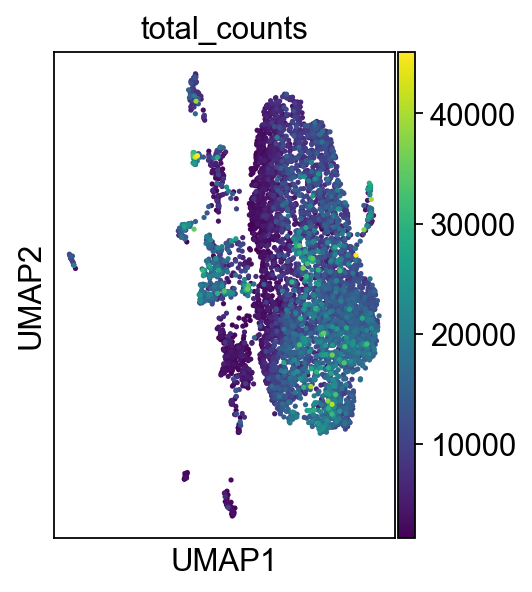

In [59]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [60]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [61]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [62]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1787 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1394 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1293 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1795 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    2189 total control genes are used. (0:00:00)
computing score 'Cluster 6'
       'Fam46c', 'Gm6139', 'Ldha-ps2', 'Gm5864'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2089 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Clust

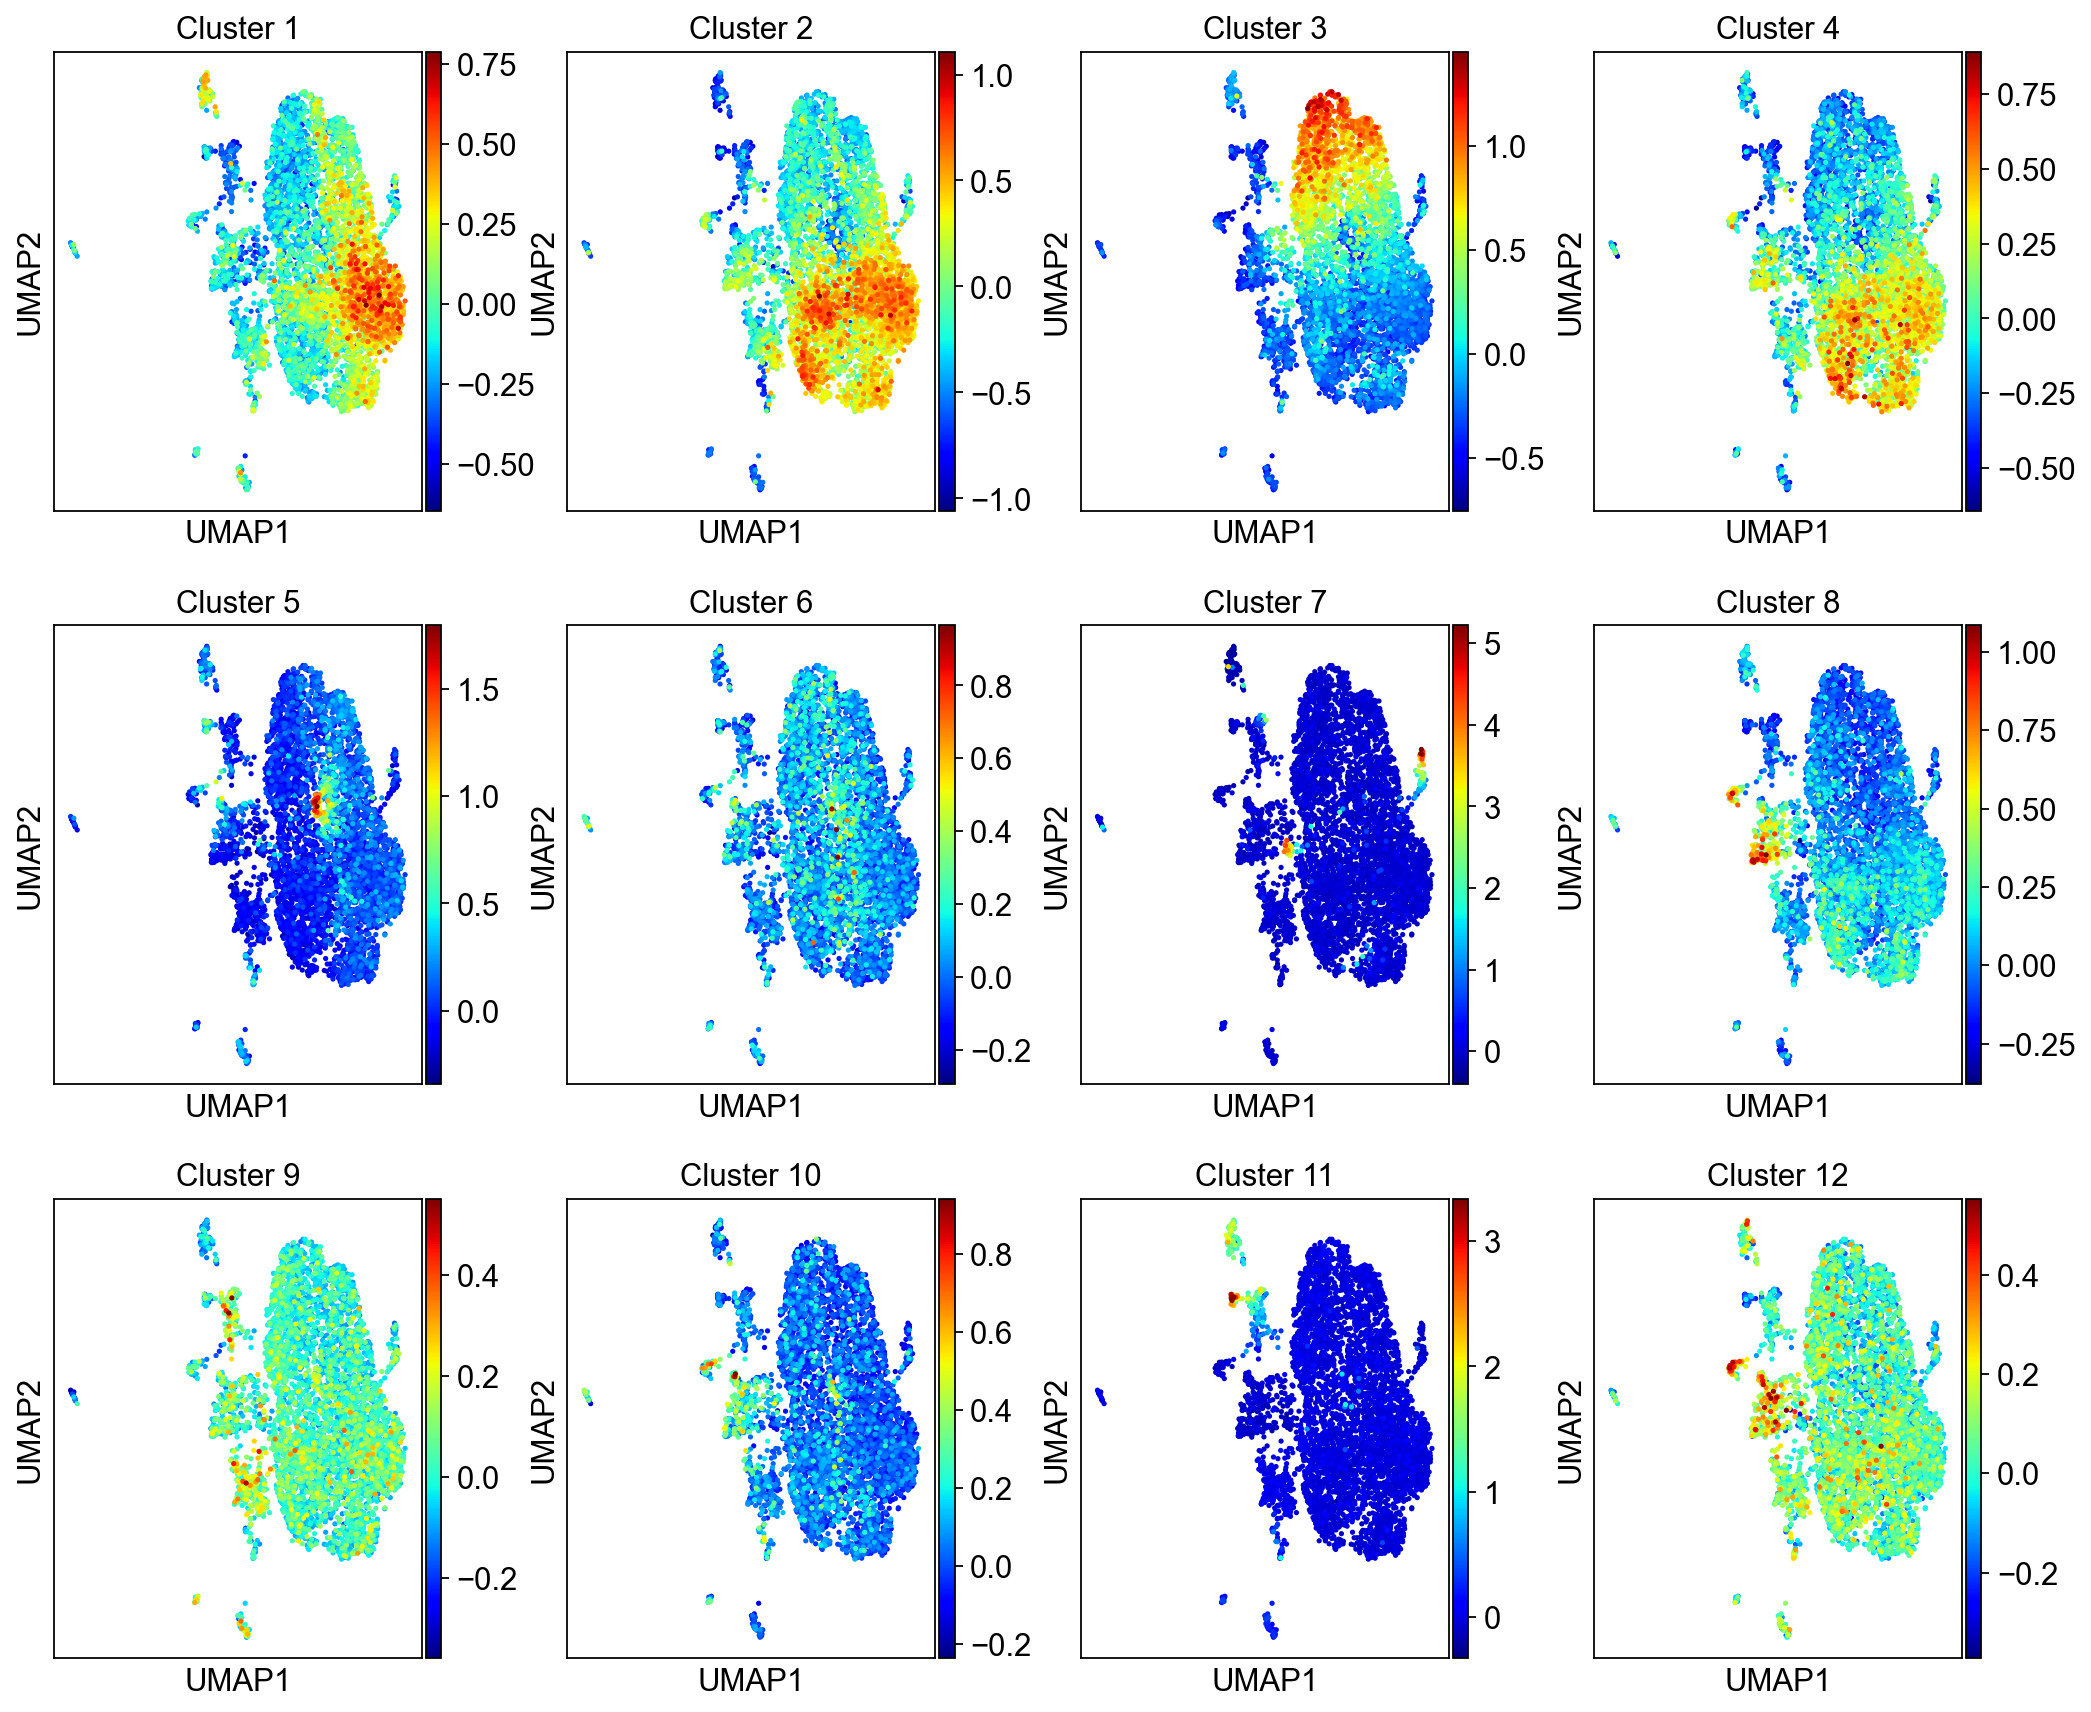

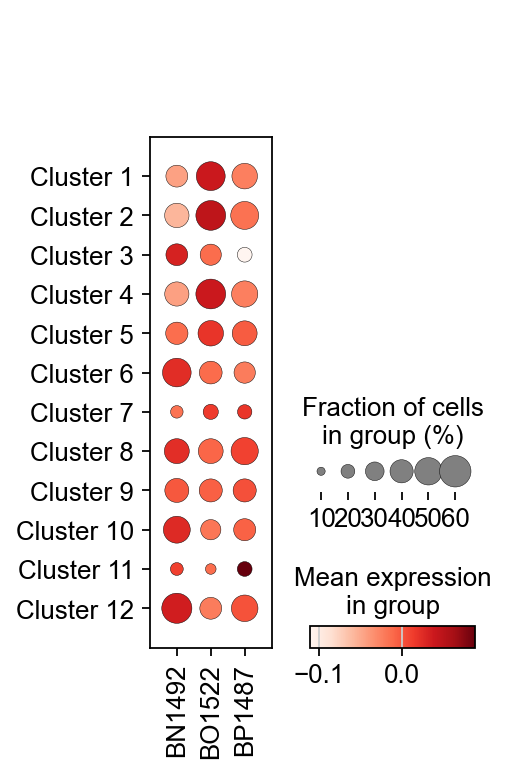

In [63]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [64]:
sc.tl.leiden(adata, resolution=0.3)

running Leiden clustering


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/3347713724.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

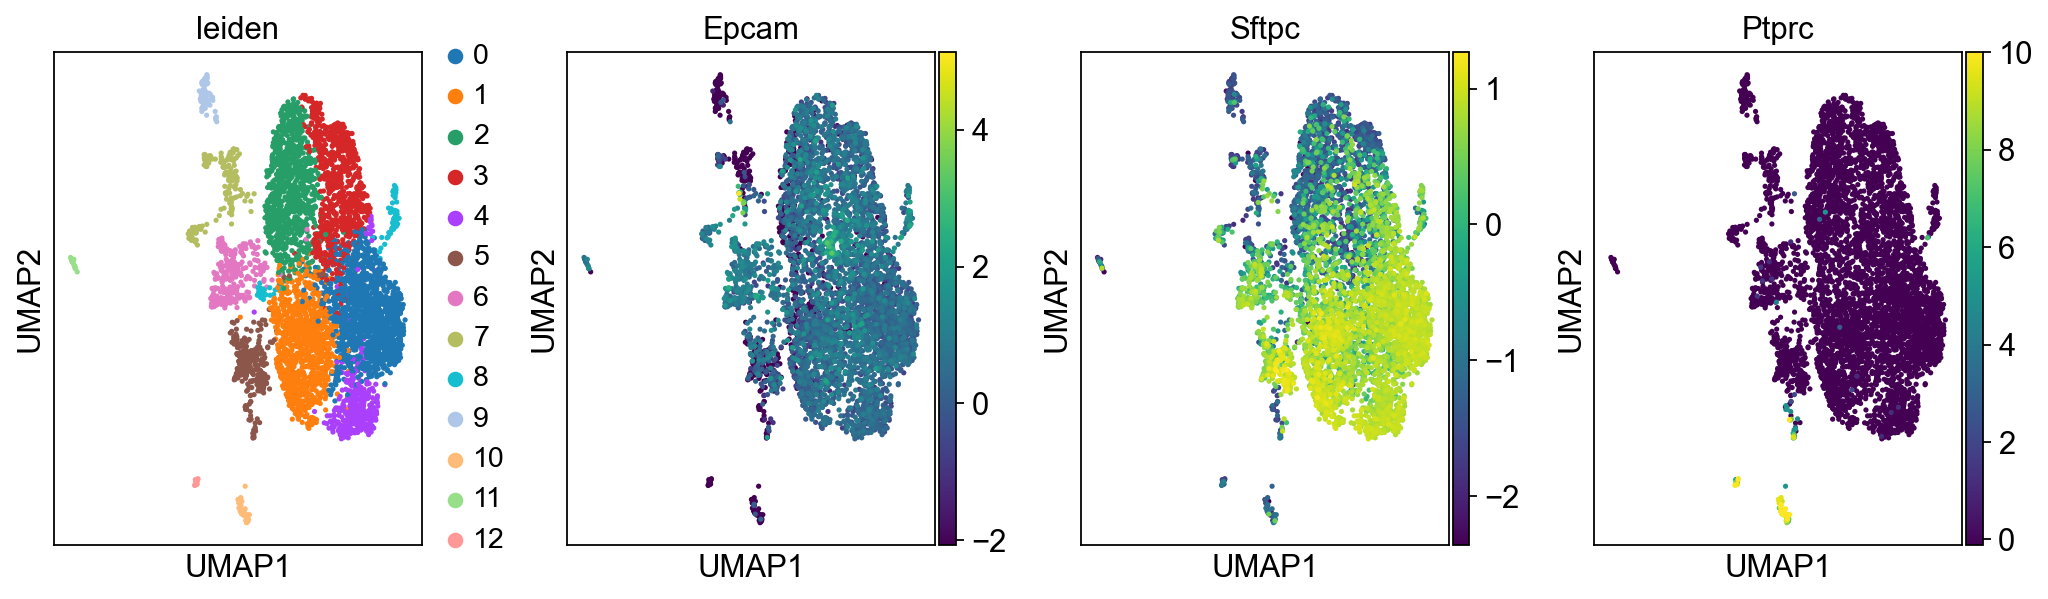

(None,)

In [65]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

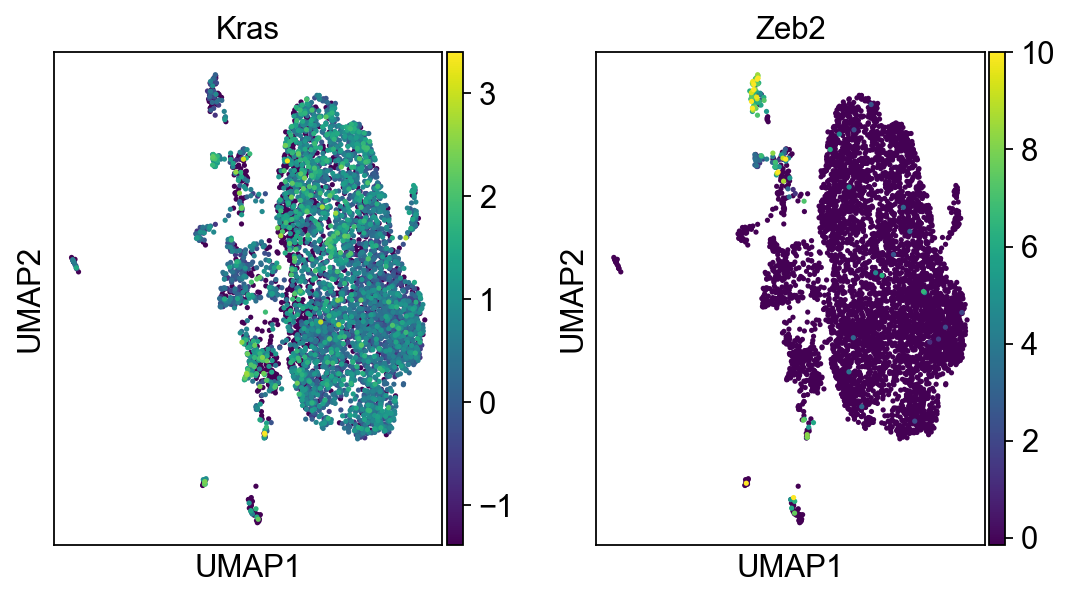

In [66]:
sc.pl.umap(adata, color=['Kras',  'Zeb2', ]) #'Cd109', #'Sox11'

Save the result.

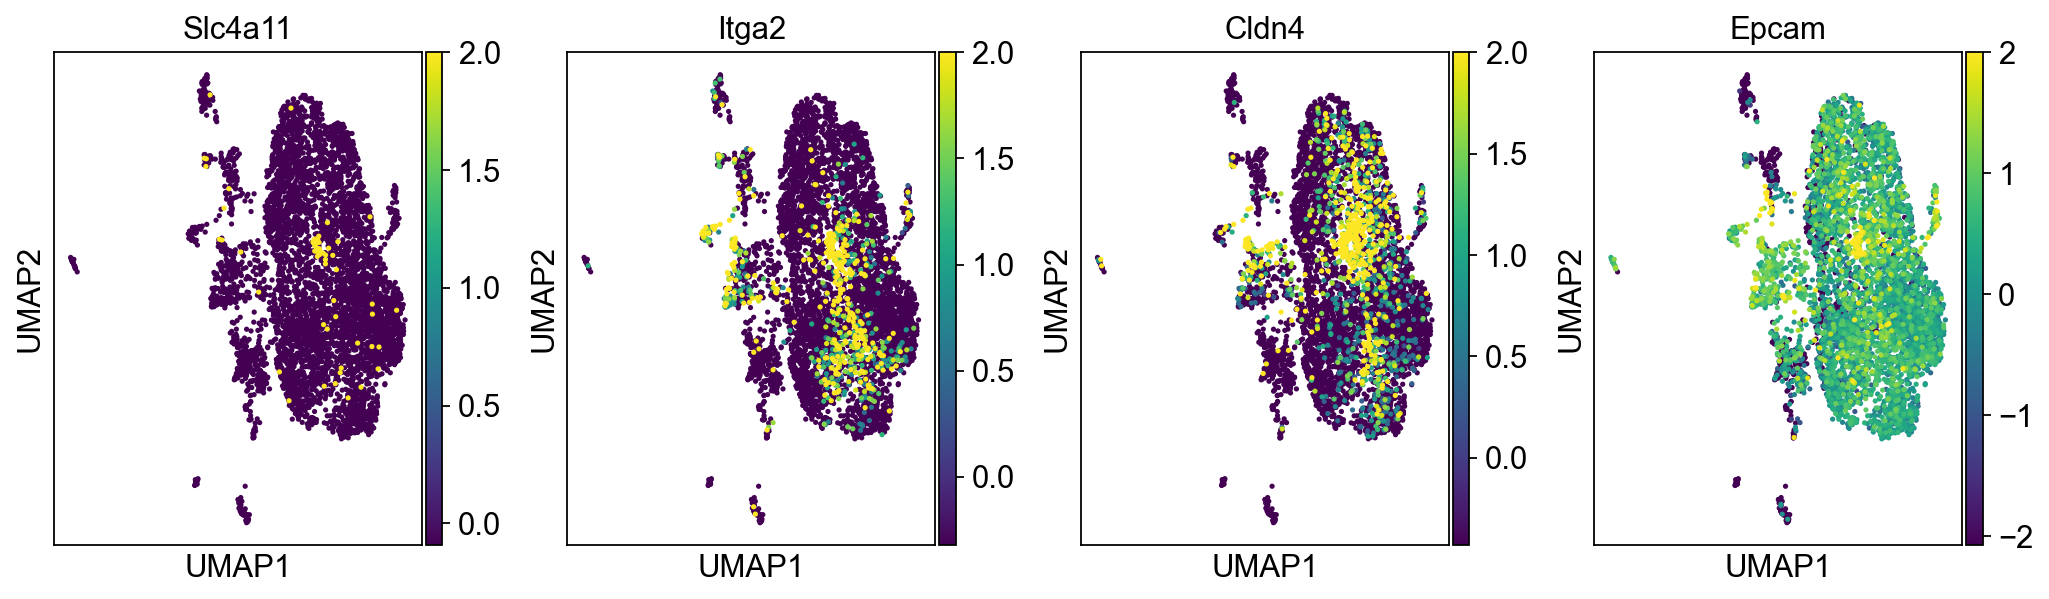

In [67]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

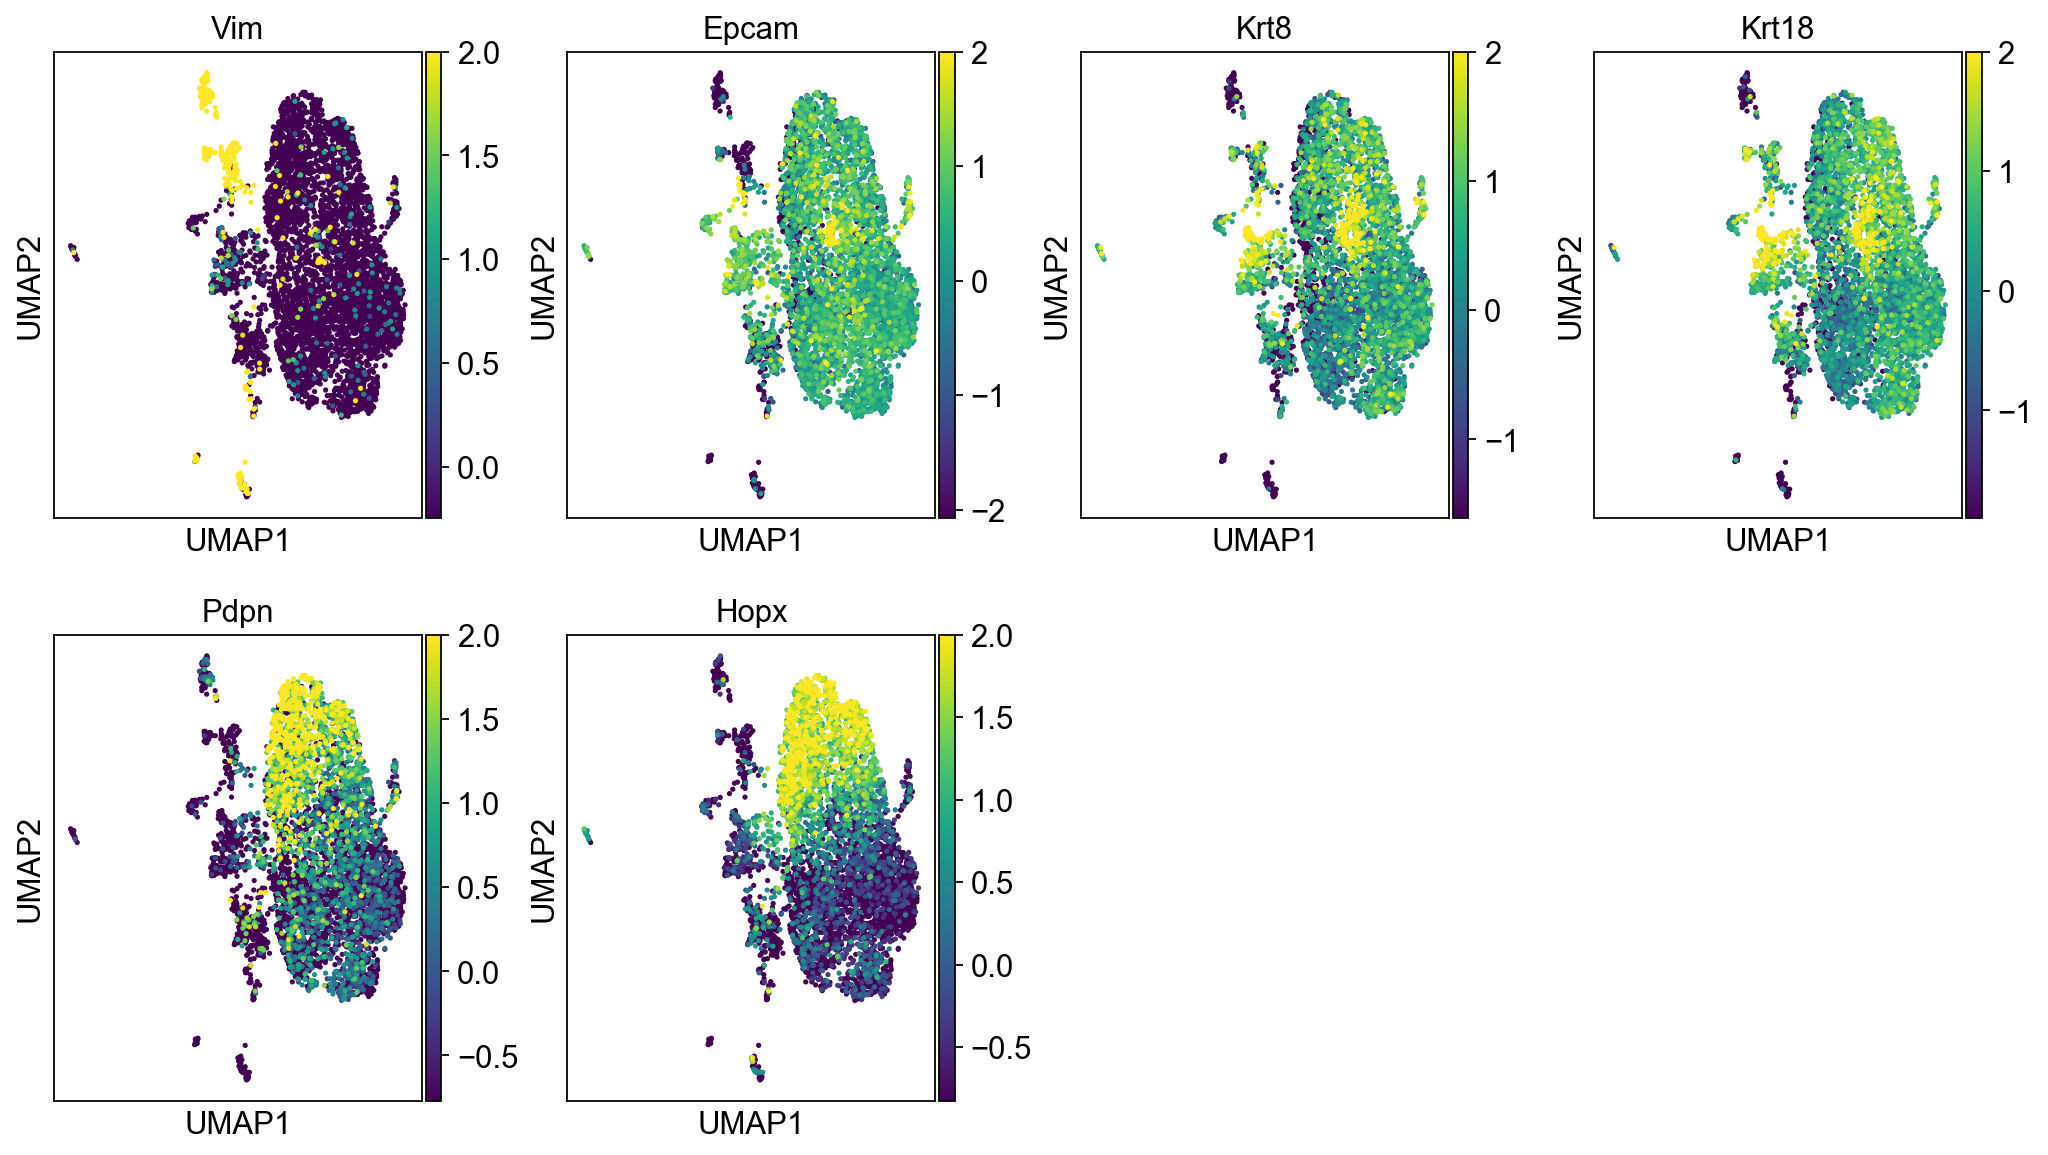

In [68]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

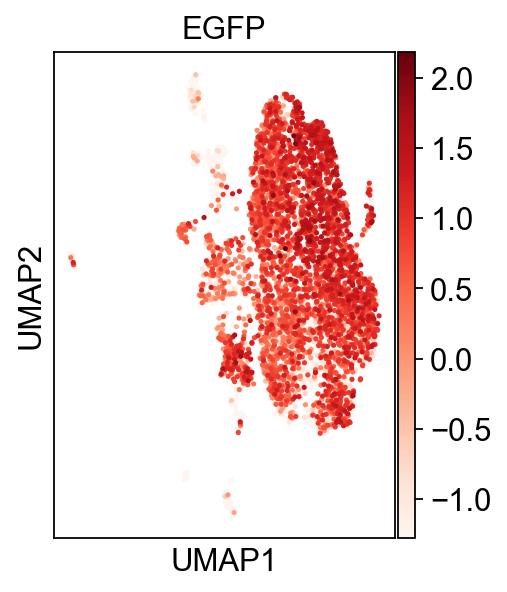

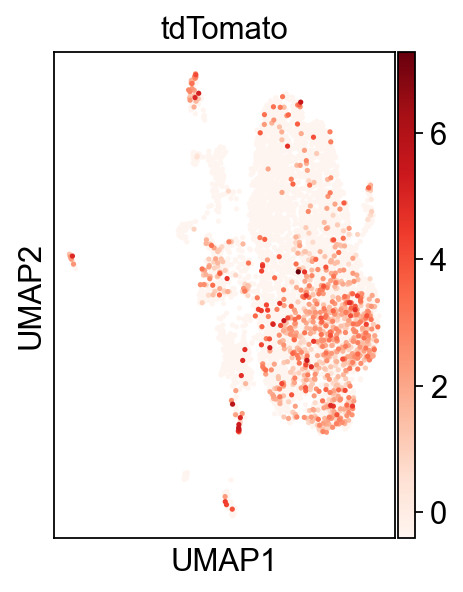

In [69]:
sc.pl.umap(adata, color=['EGFP'], cmap='Reds')
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')

In [70]:
adata

AnnData object with n_obs × n_vars = 5420 × 22894
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'EGFP_count', 'Cre_count', 'tdTomato_count', 'Group', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Classification_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

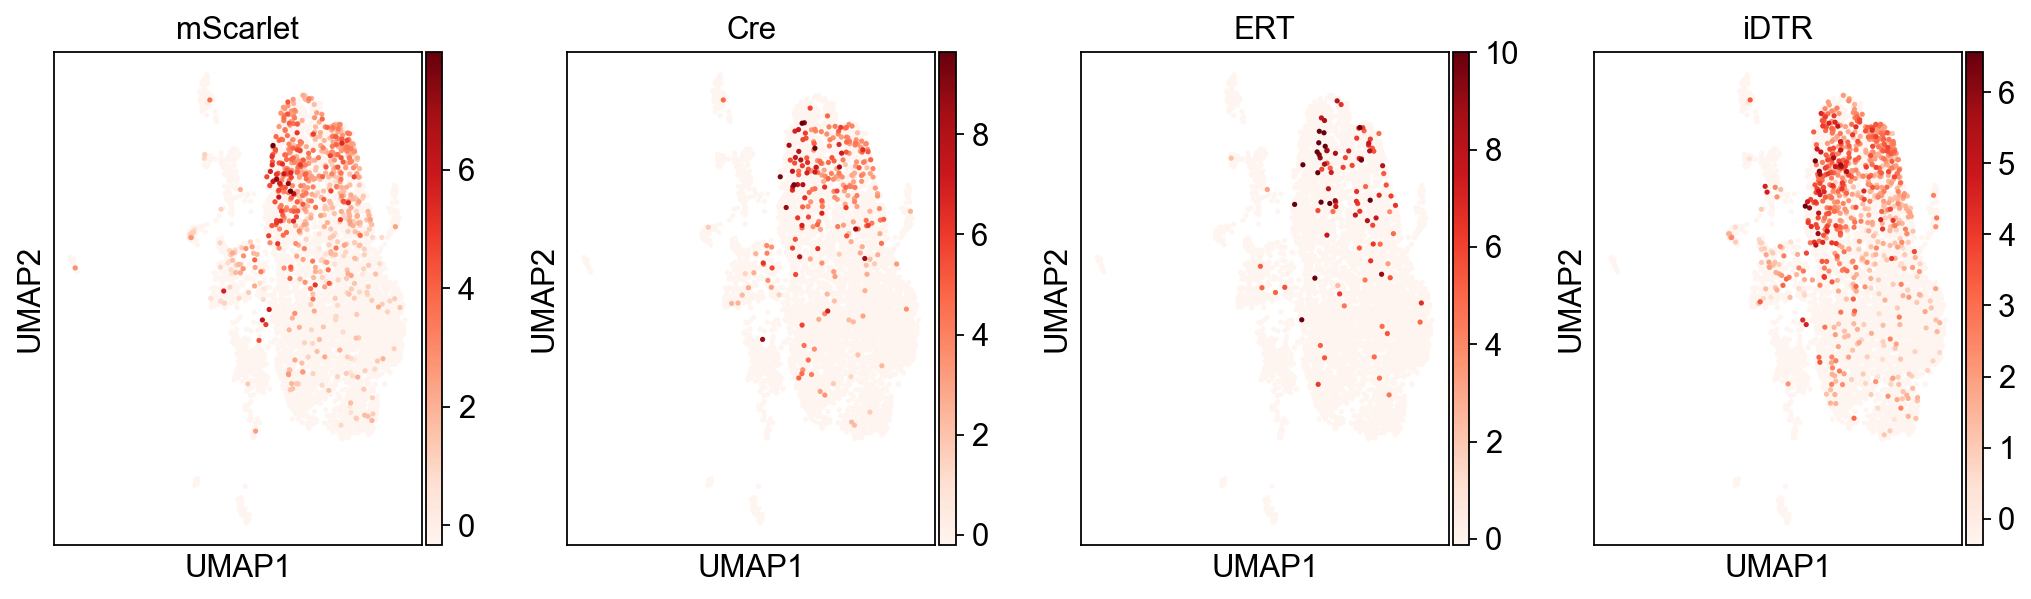

In [71]:
sc.pl.umap(adata, color=["mScarlet", "Cre", "ERT",'iDTR'], cmap='Reds')

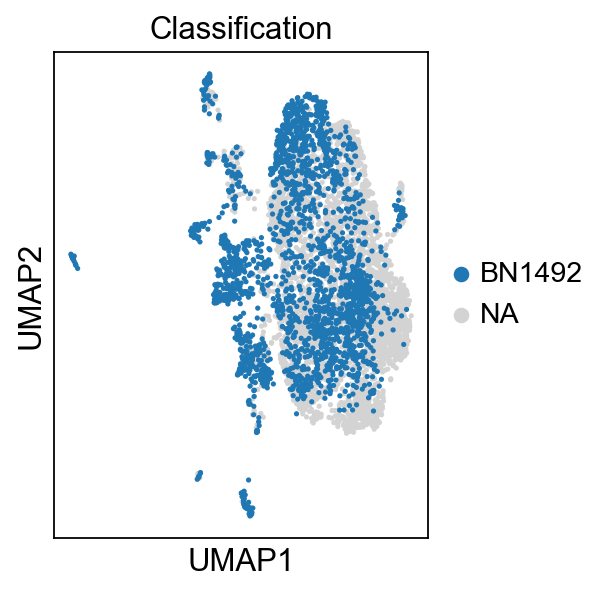

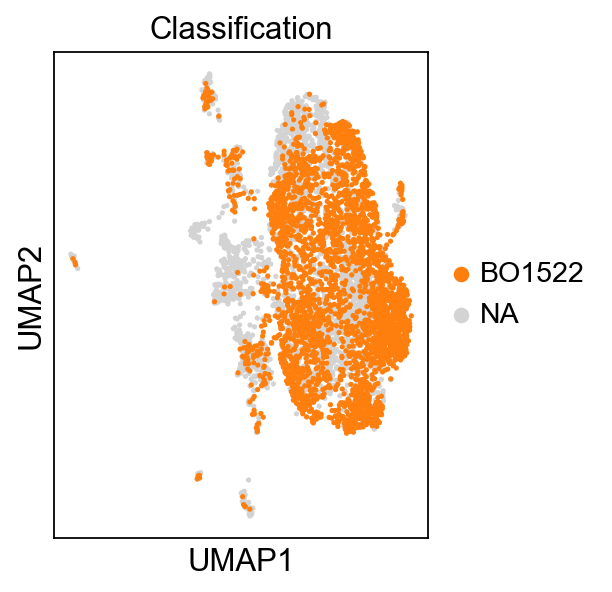

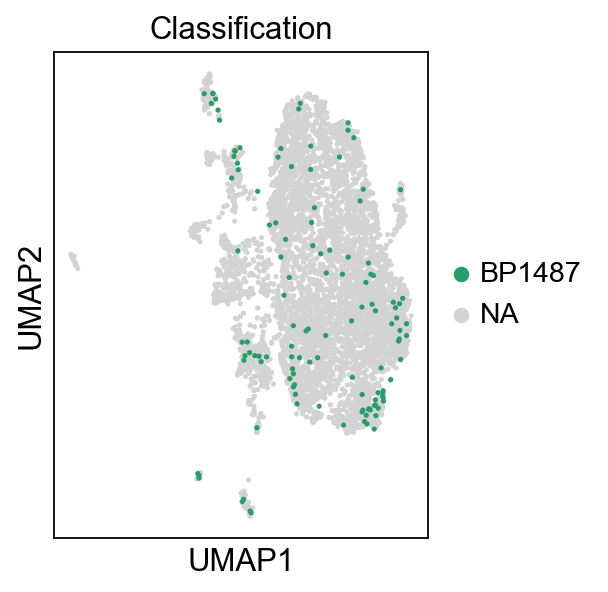

In [72]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

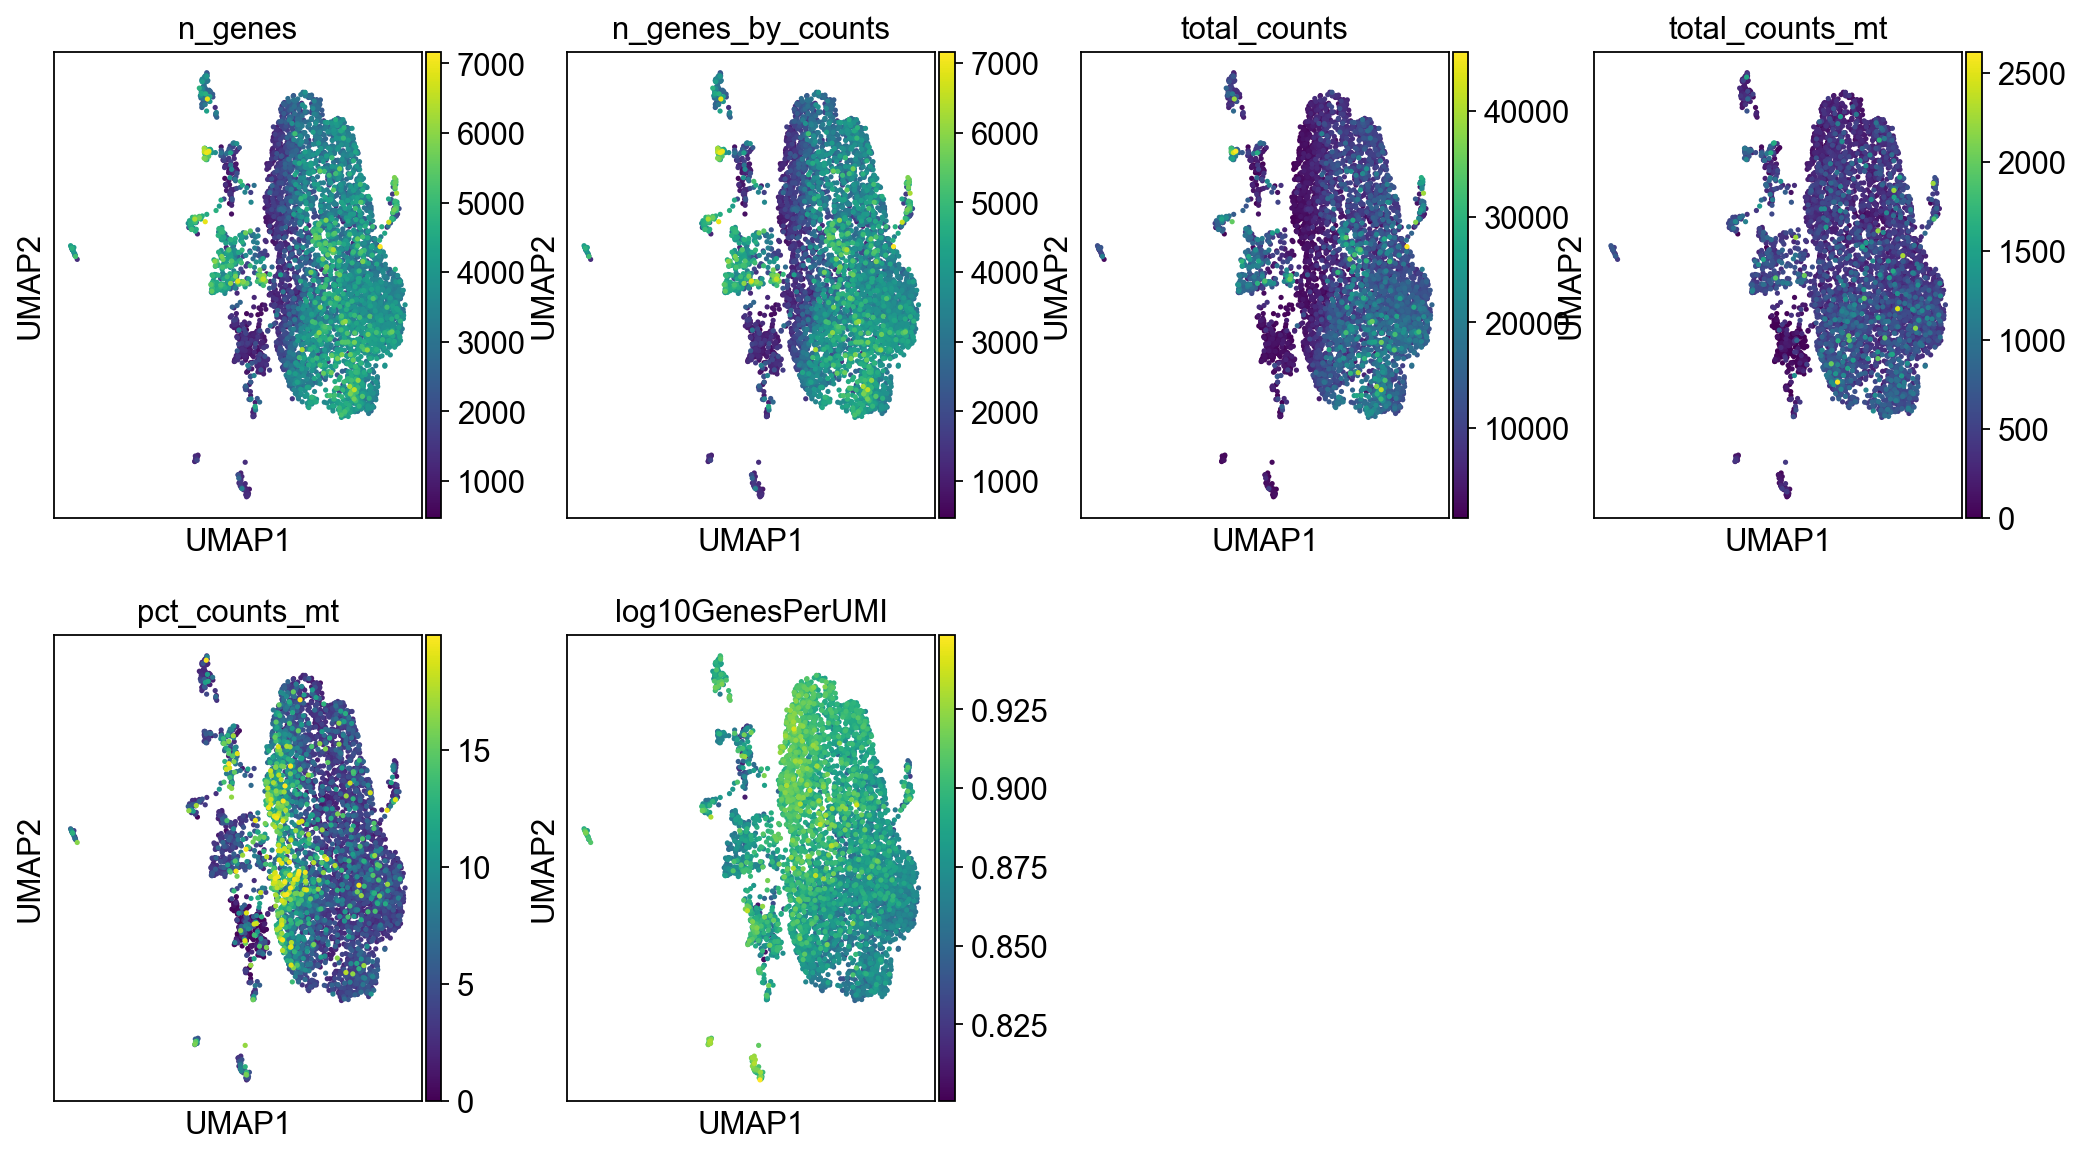

In [73]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

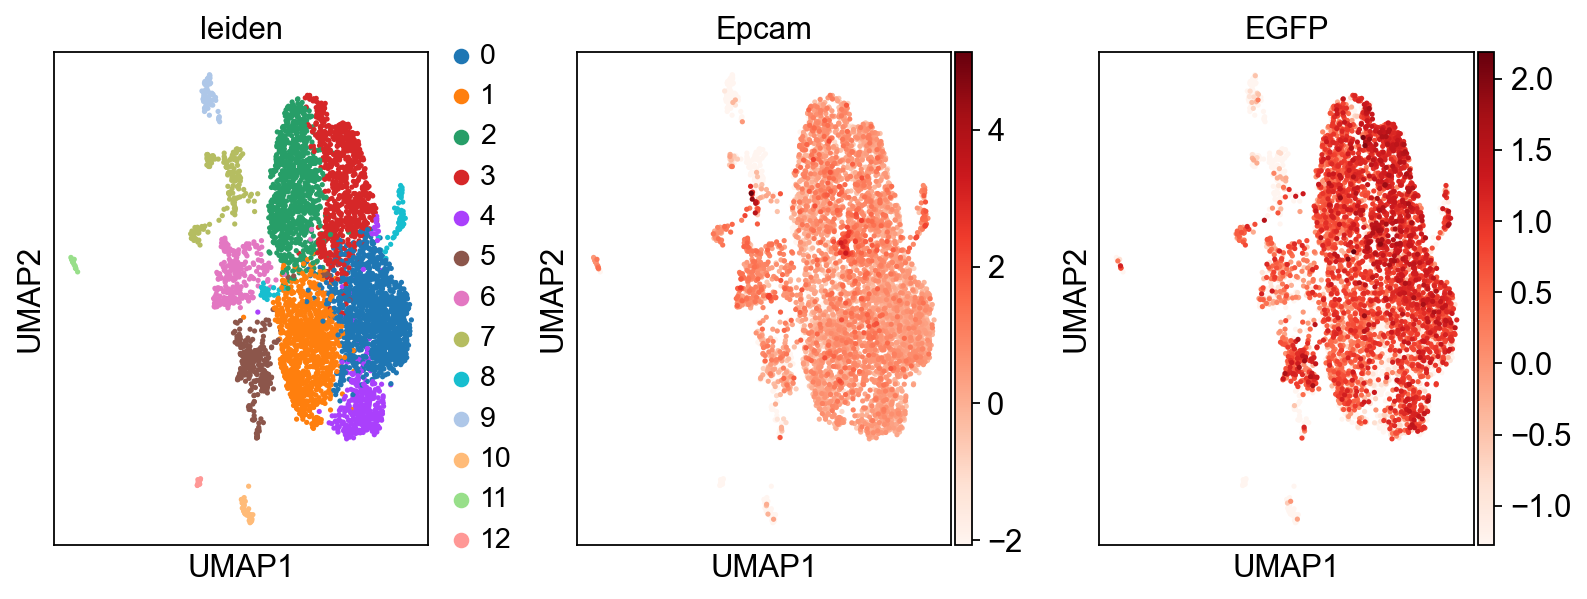

In [74]:
sc.pl.umap(adata, color=['leiden','Epcam','EGFP'],cmap="Reds")

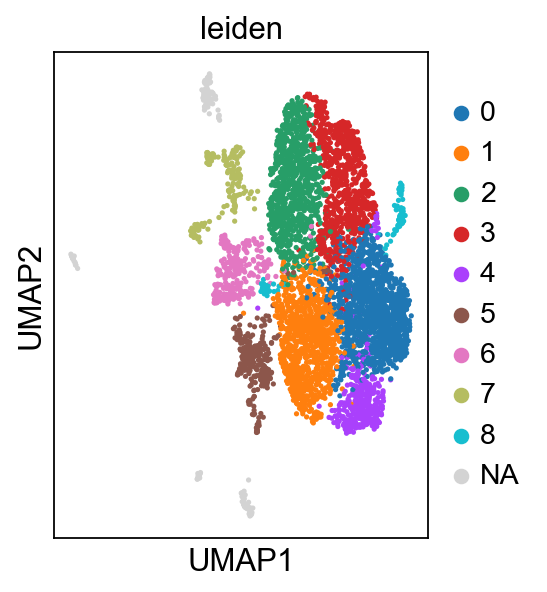

In [75]:
sc.pl.umap(adata, color=['leiden'], groups=['0','1','2','3','4','5','6','7','8'])

## Select tumor cells and write lane to h5ad

In [76]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO17131.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','1','2','3','4','5','6','7','8']),:] # keep tumor cells
del adata2

In [77]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [78]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [79]:
#will need to update this after realignment
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/2467826253.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_20499/246782

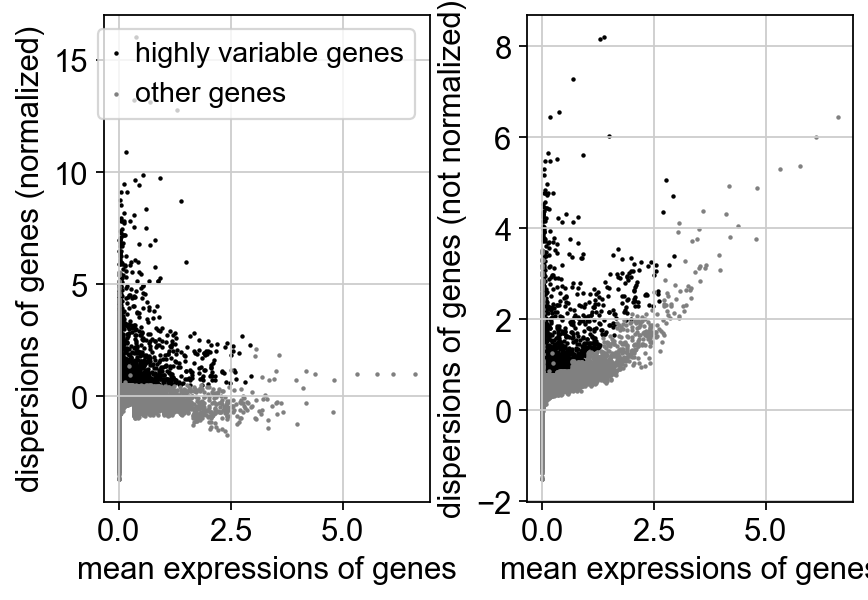

In [80]:
sc.pl.highly_variable_genes(adata)

In [81]:
adata.raw = adata

In [82]:
adata.write('write/allmice-tumor-IGO17131.h5ad', compression='gzip')
adata = sc.read('write/allmice-tumor-IGO17131.h5ad')